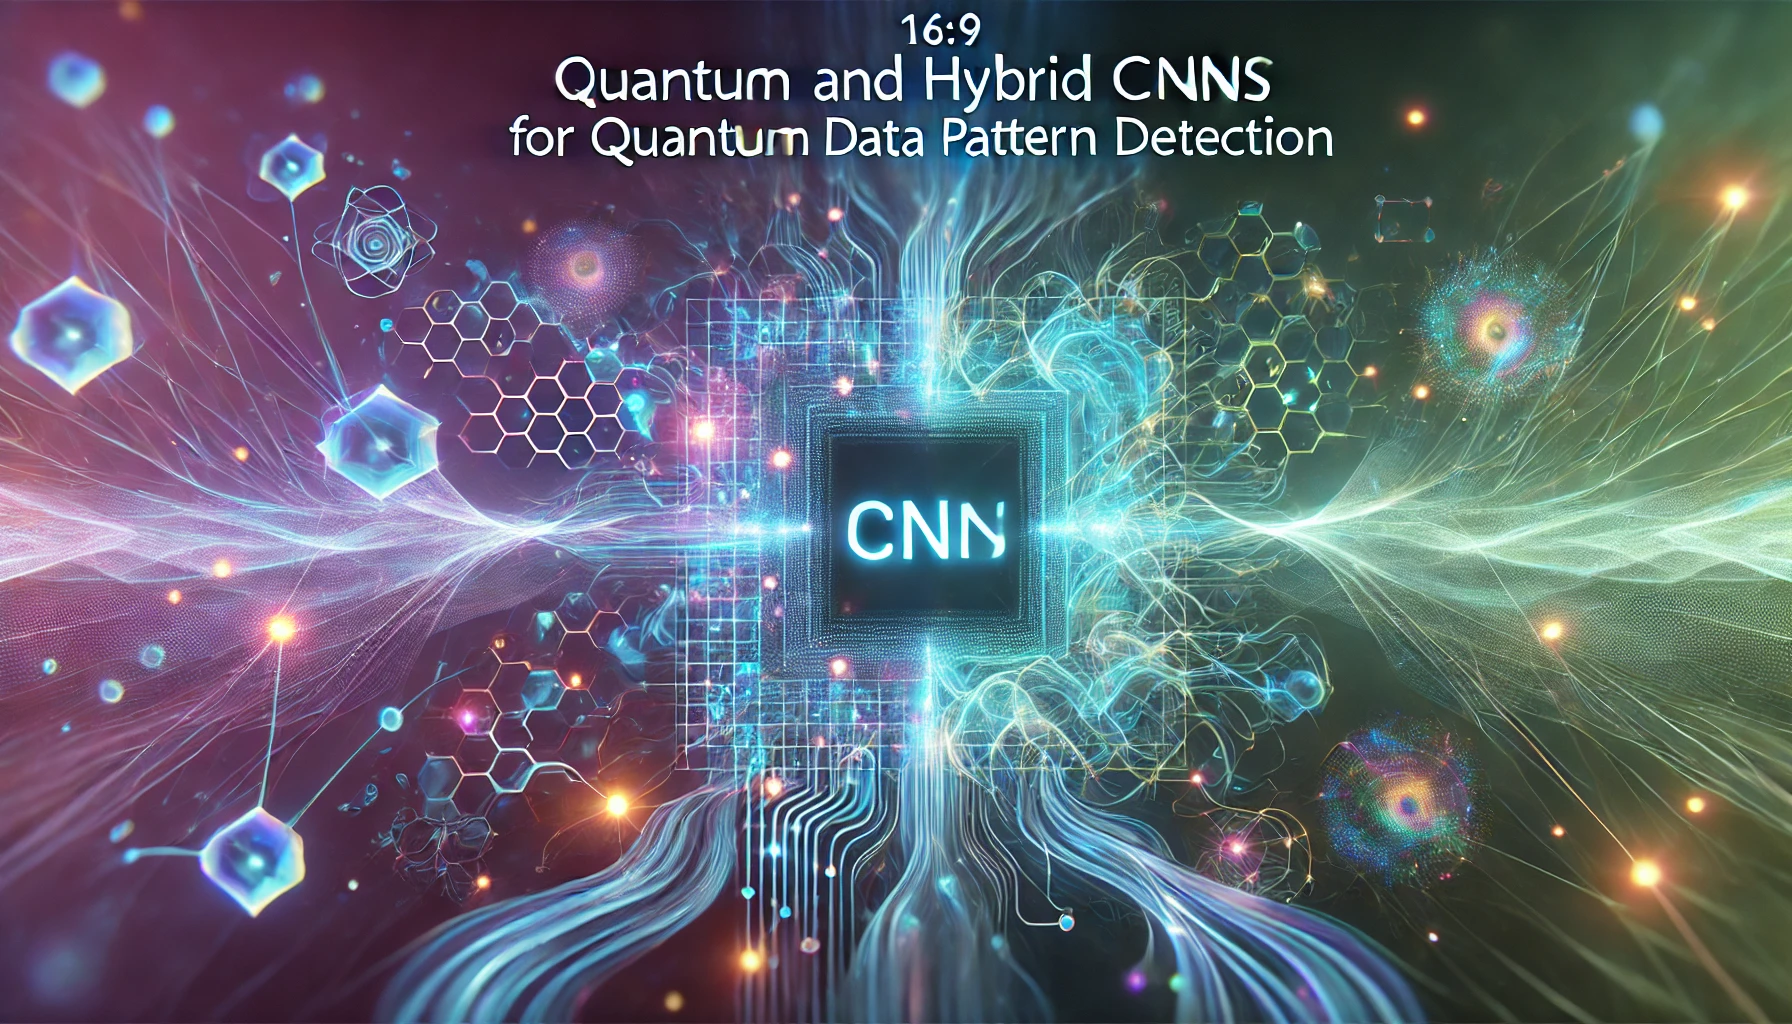

# Project Title: **Quantum and Hybrid Convolutional Neural Networks for Quantum Data Pattern Detection**
---

# Problem Statement

As quantum data becomes increasingly important for various applications, there is a need to develop machine learning models that can efficiently detect patterns in quantum data. Quantum Convolutional Neural Networks (QCNNs) and hybrid quantum-classical models offer promising approaches, but it is unclear which model type is better suited for effective feature extraction and generalization on complex quantum data. This project aims to compare the performance of QCNNs with Hybrid CNNs to identify the most effective model for detecting patterns in quantum states, such as "excited" vs. "non-excited" states in cluster data.

---

# Objectives

1. **Evaluate QCNN and Hybrid CNN architectures** to determine which model offers superior performance for detecting patterns in quantum data.
2. **Investigate the impact of multiple quantum filters** in Hybrid CNNs on feature extraction and model stability.
3. **Assess the generalization capabilities** of each model on unseen (validation) quantum data to determine robustness and accuracy.
4. **Provide insights into the advantages and limitations of purely quantum vs. quantum-classical hybrid models** for quantum machine learning tasks.

---

# Business Impact

1. **Enhanced Quantum Data Processing**: Developing efficient models for quantum data pattern detection can accelerate advances in fields like quantum computing, quantum cryptography, and quantum simulations.
2. **Optimized Quantum Resource Usage**: Hybrid models, which combine quantum and classical components, may provide performance benefits with fewer quantum resources, making them more cost-effective and feasible on near-term quantum hardware.
3. **Increased Model Generalization**: Robust quantum data processing models are crucial for applications where generalization to unseen data is essential, such as predictive modeling in finance, drug discovery, and materials science.
4. **Competitive Advantage**: Businesses that leverage hybrid quantum-classical models may gain a competitive edge by adopting models that balance quantum capabilities with classical efficiency, leading to faster, more accurate insights from quantum data.

---

# Approach

1. **Model Design**:
   - Design three models: a purely quantum QCNN, a Hybrid CNN (with a single quantum filter), and a Hybrid CNN with multiple quantum filters.
   - The QCNN consists of quantum-only layers for feature extraction and pooling.
   - The Hybrid CNN combines quantum layers for feature extraction with classical dense layers for processing.
   - The Hybrid CNN with multiple quantum filters adds parallel quantum circuits to extract richer features.

2. **Feature Extraction**:
   - Use parameterized quantum circuits in each model to extract meaningful features from quantum data, with each quantum filter focusing on specific aspects of the data.
   
3. **Training and Validation**:
   - Train all models over 25 epochs using the same dataset and assess each model's performance on unseen data using validation accuracy.
   - Monitor training and validation losses to observe overfitting and generalization.

4. **Comparison and Analysis**:
   - Evaluate model performance based on validation accuracy and stability.
   - Compare the QCNN with the hybrid models to determine whether hybrid architectures provide an advantage in terms of learning speed, feature richness, and generalization.

---

# Quantum Convolutional Neural Network

This tutorial presents a simplified implementation of a [Quantum Convolutional Neural Network (QCNN)](https://www.nature.com/articles/s41567-019-0648-8), a proposed quantum counterpart to the classical convolutional neural network (CNN). The QCNN is designed to mimic the structure and function of a classical CNN while incorporating *translational invariance*, meaning it can detect certain properties regardless of where they appear in the data—similar to how classical CNNs identify features across different regions of an image.

In this example, the QCNN is used to analyze and identify specific characteristics in a quantum data source, such as data coming from a quantum sensor or a complex quantum simulation on a device. The quantum data source in this case is a [cluster state](https://arxiv.org/pdf/quant-ph/0504097.pdf), a type of entangled quantum state that may contain an excitation. The QCNN is trained to detect the presence or absence of this excitation, learning to distinguish between different configurations of the cluster state.

The dataset used in the original research paper was based on SPT (Symmetry-Protected Topological) phase classification, where the QCNN effectively identified different phases within quantum data. This tutorial demonstrates how QCNNs can be leveraged for such tasks, showing the potential for quantum models to recognize complex patterns in quantum-specific datasets.

# Setup

In [1]:
! pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

## Install TensorFlow Quantum

In [2]:
! pip install tensorflow-quantum==0.7.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 42.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.0+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.12 which is incompatible.


In [3]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

## Import TensorFlow and the Module Dependencies

In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# Build a QCNN

## Assemble circuits in a TensorFlow graph

TensorFlow Quantum (TFQ) includes a variety of specialized layer classes tailored for constructing quantum circuits within the TensorFlow computation graph. These layers enable the seamless integration of quantum circuits and classical neural network components in a hybrid quantum-classical model. One of the key layers provided by TFQ is the `tfq.layers.AddCircuit` layer, which is derived from the `tf.keras.Layer` class in TensorFlow. This layer is specifically designed to modify the input batch of quantum circuits by adding another circuit to each one.

The `tfq.layers.AddCircuit` layer offers flexibility in its usage by allowing you to either **prepend** or **append** the additional circuit to the input batch of circuits, depending on your modeling requirements. By doing so, you can control the placement of this additional circuit in relation to the existing circuits in the batch, which can affect how quantum gates and transformations are applied to the quantum states.

This layer is particularly useful for constructing complex quantum models where certain operations need to be consistently applied across multiple circuits. For example, you may want to apply a sequence of gates to initialize each circuit or to introduce specific transformations that help guide the learning process. The `AddCircuit` layer allows you to achieve this within the TensorFlow framework, maintaining compatibility with classical neural network layers.

In practice, the `AddCircuit` layer can be visualized as shown in the following figure, where the additional circuit is either placed at the beginning or the end of each input circuit, depending on whether you choose to prepend or append. This ability to configure circuit positioning within the graph gives researchers and developers a powerful tool to experiment with different circuit configurations and quantum-classical interactions, advancing the capabilities of hybrid quantum-classical models.

<img src="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/images/qcnn_1.png?raw=1" width="700">

The following snippet uses this layer:

In [5]:
qubit = cirq.GridQubit(0, 0)

In [6]:
# Define some circuits.
circuit1 = cirq.Circuit(cirq.X(qubit))
circuit2 = cirq.Circuit(cirq.H(qubit))

In [7]:
# Convert to a tensor.
input_circuit_tensor = tfq.convert_to_tensor([circuit1, circuit2])

In [8]:
# Define a circuit that we want to append
y_circuit = cirq.Circuit(cirq.Y(qubit))

In [9]:
# Instantiate our layer
y_appender = tfq.layers.AddCircuit()

In [10]:
# Run our circuit tensor through the layer and save the output.
output_circuit_tensor = y_appender(input_circuit_tensor, append=y_circuit)

## Examine the Input Tensor

In [11]:
print(tfq.from_tensor(input_circuit_tensor))

[cirq.Circuit([
     cirq.Moment(
         cirq.X(cirq.GridQubit(0, 0)),
     ),
 ])
 cirq.Circuit([
     cirq.Moment(
         cirq.H(cirq.GridQubit(0, 0)),
     ),
 ])                                   ]


## Examine the Output Tensor

In [12]:
print(tfq.from_tensor(output_circuit_tensor))

[cirq.Circuit([
     cirq.Moment(
         cirq.X(cirq.GridQubit(0, 0)),
     ),
     cirq.Moment(
         cirq.Y(cirq.GridQubit(0, 0)),
     ),
 ])
 cirq.Circuit([
     cirq.Moment(
         cirq.H(cirq.GridQubit(0, 0)),
     ),
     cirq.Moment(
         cirq.Y(cirq.GridQubit(0, 0)),
     ),
 ])                                   ]


While it is possible to run the examples below without using `tfq.layers.AddCircuit`, it's a good opportunity to understand how complex functionality can be embedded into TensorFlow compute graphs.

## Problem overview

In this project, you’ll create a *cluster state* and train a quantum classifier to determine whether the state is "excited" or not. The cluster state is known for being highly entangled, but it’s not necessarily challenging for a classical computer to analyze. For simplicity, this dataset is less complex than the one used in the original research paper, providing an accessible foundation for demonstrating quantum classification.

To accomplish this classification task, you’ll implement a deep, [MERA](https://arxiv.org/pdf/quant-ph/0610099.pdf)-like Quantum Convolutional Neural Network (QCNN) architecture. This choice is motivated by two key characteristics of the cluster state:

1. **Translational Invariance**: Like a QCNN, the cluster state arranged on a ring exhibits translational invariance, meaning its properties remain consistent even when shifted around the ring. This invariance allows QCNN architectures to process the state effectively without losing information due to shifts in position.
   
2. **High Entanglement**: The cluster state has a significant level of entanglement across its qubits, which is ideal for demonstrating the QCNN's strength in processing quantum data. The QCNN’s layered structure, inspired by MERA (Multiscale Entanglement Renormalization Ansatz), is designed to reduce entanglement systematically, allowing for an efficient representation of highly entangled states.

In this QCNN architecture, the classification task will be achieved by ultimately reading out a single qubit. The QCNN layers will perform entanglement-reducing operations, gradually condensing the information in the cluster state until it can be classified based on the final qubit’s state.

***What is an "Excited" Cluster State?***

In this project, an "excited" cluster state is defined as a cluster state where any of the qubits has undergone a rotation along the x-axis via a `cirq.rx` gate. The presence of this rotation, applied to one or more qubits, disrupts the original cluster state configuration, creating an excitation that the classifier will be trained to detect.

The illustration below shows a QCNN structure for this task. It includes layers for quantum convolution (QConv) and quantum pooling (QPool), which systematically reduce the complexity of the quantum state while preserving essential information for classification.

<img src="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/images/qcnn_2.png?raw=1" width="1000">

***QConv and QPool Layers***

In this QCNN model, the **QConv** and **QPool** layers are used to reduce the entanglement in the cluster state, allowing for a more efficient processing of the highly entangled data. These layers function similarly to their classical counterparts but are adapted to operate on quantum data:

- **QConv (Quantum Convolution)**: The QConv layer applies a sequence of quantum gates that "scan" the state, interacting with neighboring qubits and preserving translational invariance. This operation extracts relevant features from localized regions of the quantum state, analogous to how classical convolutional layers detect patterns in image regions.

- **QPool (Quantum Pooling)**: The QPool layer reduces the number of qubits by "pooling" information, much like classical pooling layers downsample feature maps. This pooling process helps reduce the complexity of the quantum state and focuses on the essential information, preparing it for the final classification step.

These layers are discussed further in the tutorial, providing a breakdown of how each operation functions within the QCNN and contributes to the model’s ability to detect excitations in the cluster state.

By following this architecture, you’ll leverage the QCNN's unique ability to manage highly entangled quantum data, enabling it to effectively classify the cluster state as excited or non-excited based on the presence of a rotation applied to its qubits. This project illustrates the QCNN’s strength in detecting subtle variations in quantum states, showcasing a practical application of quantum machine learning in analyzing quantum data.

## Building blocks for TensorFlow

<img src="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/images/qcnn_3.png?raw=1" width="1000">

To tackle this problem using TensorFlow Quantum, we can build a quantum machine learning model that leverages the hybrid approach of integrating quantum circuits with classical deep learning tools in TensorFlow. The main goal is to design a classifier that can differentiate between an "excited" and a "non-excited" cluster state, using quantum layers to perform the essential computations. Here’s a breakdown of the key steps to implement this solution:

1. **Input Preparation**:
   - The model input is a *circuit tensor*, a batch of quantum circuits that serve as the dataset for the model. Each circuit tensor will represent either an "excited" or "non-excited" cluster state.
   - To create the distinction between these two states, each circuit tensor will either be an empty circuit (indicating a non-excited state) or contain an X gate applied to a particular qubit (representing an excitation). This X gate, or Pauli-X operation, flips the qubit's state, introducing an excitation in the cluster state.
   - This setup creates a clear, binary classification problem: circuits with an X gate on any qubit are labeled as excited, while those without the X gate are labeled as non-excited.

2. **Building the Quantum Model Components**:
   - TensorFlow Quantum provides specialized layers, including `tfq.layers.AddCircuit`, that make it easy to build and manipulate quantum circuits within the TensorFlow computation graph.
   - In this model, `tfq.layers.AddCircuit` layers are used to define and add quantum components to the input circuit tensor. Each `AddCircuit` layer can append or prepend a predefined set of quantum gates or operations to the input circuits, allowing for flexible circuit construction.
   - These added circuits can implement necessary operations for the quantum convolutional neural network (QCNN), such as the Quantum Convolution (QConv) and Quantum Pooling (QPool) layers. By stacking `AddCircuit` layers, you can build the QCNN structure, enabling the model to progressively extract features from the input circuits.

3. **Inference with a Parametrized Quantum Circuit (PQC) Layer**:
   - For the final inference step, a `tfq.layers.PQC` (Parametrized Quantum Circuit) layer is used. The PQC layer applies a quantum circuit with trainable parameters and measures specific observables as the output.
   - In this case, the PQC layer measures the expectation value of the Pauli-Z operator, denoted as ⟨𝑍⟩. This measurement provides an output value that can be used for binary classification.
   - The model interprets the result of ⟨𝑍⟩ as follows:
     - If ⟨𝑍⟩ is close to 1, it corresponds to a label of 1, indicating an "excited" state.
     - If ⟨𝑍⟩ is close to -1, it corresponds to a label of -1, indicating a "non-excited" state.
   - This classification rule allows the PQC layer to output a binary prediction based on the input circuit’s quantum state.

***Overview of Model Architecture***

To summarize, this approach involves creating a quantum-classical hybrid model in TensorFlow Quantum. The architecture includes the following components:

- **Input Layer**: A circuit tensor representing either an empty circuit (non-excited) or a circuit with an X gate applied to one qubit (excited).
- **Quantum Layers (AddCircuit Layers)**: Layers that add specific quantum operations to the circuits, forming the QConv and QPool layers in the QCNN architecture. These operations process the input circuit, gradually reducing entanglement and preparing it for the final classification.
- **Output Layer (PQC Layer)**: A `tfq.layers.PQC` layer that performs a measurement of ⟨𝑍⟩ on the output qubit, determining whether the state is excited or non-excited based on the measurement outcome.

This approach highlights the power of TensorFlow Quantum in constructing and training hybrid quantum-classical models. By combining circuit tensors, `AddCircuit` layers, and PQC layers, TensorFlow Quantum enables the design of sophisticated quantum machine learning models that can analyze and classify quantum data effectively. This model is designed to be straightforward yet effective for tasks involving quantum state classification, illustrating the utility of quantum neural networks in analyzing highly entangled quantum data.

## Data

Before constructing the model, it’s essential to generate the dataset that will be used for training and evaluating the quantum classifier. In this case, the dataset will consist of *excited* and *non-excited* cluster states. Here’s how this dataset is created, along with the criteria for labeling each data point:

1. **Cluster State Setup**:
   - The cluster state serves as the base state for each sample in the dataset. A cluster state is a highly entangled quantum state created by applying a sequence of controlled-Z (CZ) gates to a set of qubits initialized in the |+⟩ state (created using Hadamard gates). In this setup, the cluster state acts as the baseline to which excitations may or may not be applied.

2. **Adding Excitations with `cirq.rx` Gates**:
   - To introduce excitations, rotations along the x-axis are applied to one or more qubits in the cluster state. Specifically, the `cirq.rx` gate is used to perform an x-axis rotation by a certain angle.
   - Each rotation has a specific angle parameter. The magnitude of this rotation determines whether it qualifies as an "excitation" or not:
     - If the rotation angle is *large enough*, the state is considered excited and is labeled `1`.
     - If the rotation angle is *not large enough*, the state is considered non-excited and is labeled `-1`.
   - This distinction allows for a binary classification problem, where the goal is to detect whether the cluster state contains a significant excitation or not.

3. **Labeling Criteria**:
   - The threshold for what constitutes a “large enough” rotation is defined based on experimental design. For instance, rotations greater than π/4 might be labeled as `1` (excited), while rotations less than or equal to π/4 are labeled as `-1` (non-excited). This threshold can be adjusted based on the specifics of the classification task and the desired sensitivity.
   - By setting up this labeling criteria, each sample in the dataset receives a clear label (`1` for excited or `-1` for non-excited), allowing the model to learn the difference between the two states.

4. **Generating the Dataset**:
   - To build the dataset, a series of cluster states are created, with varying x-axis rotations applied to different qubits according to the threshold criteria.
   - For each sample, a cluster state is generated and an `cirq.rx` rotation (with a random angle) is applied to a randomly selected qubit. Depending on the angle of rotation, the sample is labeled accordingly.
   - This process is repeated to generate a balanced dataset of excited and non-excited states, with labels of `1` and `-1`, respectively.

5. **Purpose of the Dataset**:
   - This dataset allows the quantum classifier to learn how to distinguish between different states based on subtle changes in the quantum state caused by x-axis rotations. By training on this dataset, the model will learn to detect significant excitations in cluster states, a useful capability for quantum data analysis.

In summary, this data generation process creates a labeled dataset of cluster states with and without excitations. Excitations are introduced using `cirq.rx` gates, and the rotation angle serves as the basis for labeling each sample. This simplified dataset provides an accessible way to train the quantum classifier, as it allows the model to learn how to identify states with significant excitations from the rest.

In [13]:
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.

    excitations = []
    labels = []

    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)

    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

You can see that just like with regular machine learning you create a training and testing set to use to benchmark the model. You can quickly look at some datapoints with:

In [14]:
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))

In [15]:
print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])

Input: (0, 0): ───X^-0.837─── Output: -1
Input: (0, 1): ───X^-0.968─── Output: -1


## Define layers

Now define the layers shown in the figure above in TensorFlow.

### Cluster State

The first step is to define the <a href="https://arxiv.org/pdf/quant-ph/0504097.pdf" class="external">cluster state</a> using <a href="https://github.com/quantumlib/Cirq" class="external">Cirq</a>, a Google-provided framework for programming quantum circuits. Since this is a static part of the model, embed it using the `tfq.layers.AddCircuit` functionality.

In [16]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))

    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))

    return circuit

Display a cluster state circuit for a rectangle of <a href="https://cirq.readthedocs.io/en/stable/generated/cirq.GridQubit.html" class="external"><code>cirq.GridQubit</code></a>s:

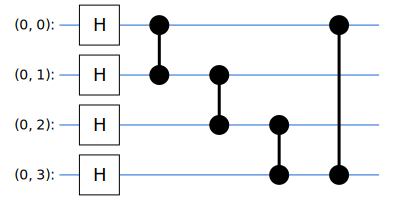

In [17]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

This shows a quantum circuit with four qubits (labeled `(0, 0)`, `(0, 1)`, `(0, 2)`, and `(0, 3)`) organized in a grid-like structure. Each qubit is initialized with a Hadamard gate (`H`), followed by a series of controlled operations that form an entangled cluster state. Here’s a breakdown of the components and structure of this circuit:

***Circuit Breakdown***

1. **Hadamard Gates (`H`)**:
   - Each qubit has a Hadamard gate applied at the beginning. The Hadamard gate creates a superposition for each qubit, placing them in an equal probability state of |0⟩ and |1⟩.
   - Applying Hadamard gates to all qubits prepares them in a |+⟩ state, which serves as the basis for building entanglement across the qubits.

2. **Controlled-Z (CZ) Gates**:
   - The black dots connected by lines represent controlled operations, likely Controlled-Z (CZ) gates, which are common in cluster state generation.
   - In a CZ gate, the phase of the target qubit is flipped (from |+⟩ to |−⟩) if the control qubit is in the |1⟩ state. This gate creates entanglement between pairs of qubits.
   - The placement of the CZ gates in this circuit follows a pattern that entangles each qubit with its neighboring qubits, creating a highly entangled state.

3. **Layered Structure**:
   - The circuit shows layers of entangling gates, with each layer connecting different pairs of qubits. This layered approach gradually builds up the entanglement in the system.
   - By arranging the CZ gates in this pattern, the circuit entangles the qubits in a structure similar to a 1D cluster state, where each qubit is entangled with its immediate neighbors.

***Purpose of the Circuit***

This setup is typical for creating a *cluster state*, a foundational entangled state in quantum computing. Cluster states serve as a starting point for various quantum algorithms, particularly those in measurement-based quantum computation. In the context of a Quantum Convolutional Neural Network (QCNN), this entangled state acts as the input state, which will later undergo further transformations (quantum convolution and pooling) to extract features for classification.

***Key Points***

- **Cluster State Preparation**: The initial Hadamard gates put each qubit in superposition, and the CZ gates entangle them, creating a cluster state.
- **Translational Invariance**: The arrangement of gates makes the cluster state translationally invariant, meaning that the pattern of entanglement remains consistent across the qubits.
- **Input for QCNN**: This entangled state will serve as the input for a QCNN, where further layers will be applied to detect specific properties (like excitations) in the state.

In summary, this circuit creates a 1D cluster state using Hadamard and CZ gates. It initializes the qubits in superposition and then entangles them with neighboring qubits, forming the base state for further processing in the quantum convolutional network.

### QCNN Layers

To construct the Quantum Convolutional Neural Network (QCNN) as outlined in the [Cong and Lukin QCNN paper](https://arxiv.org/abs/1810.03787), we need to define a series of layers that will process the cluster state and detect excitations. The QCNN architecture includes layers inspired by classical CNNs but adapted to operate on quantum data. This includes *quantum convolution* and *quantum pooling* layers, which reduce the complexity of the entangled state while preserving essential information for classification.

Here’s a step-by-step guide to setting up these layers, along with the prerequisites:

***1. Prerequisites: One- and Two-Qubit Parameterized Unitary Matrices***

The [Tucci paper](https://arxiv.org/abs/quant-ph/0507171) introduces parameterized unitary matrices for one- and two-qubit gates. These matrices allow us to represent general quantum operations in a parameterized form, which is essential for building trainable quantum layers in the QCNN. Below are the types of parameterized gates needed:

- **One-Qubit Unitary Matrix**:
  - A general one-qubit gate can be represented by a parameterized unitary matrix $ U(\theta, \phi, \lambda) $, which has three parameters:
     
  $$ U(\theta, \phi, \lambda) = \begin{pmatrix} \cos(\theta/2) & -e^{i\lambda}\sin(\theta/2) \\ e^{i\phi}\sin(\theta/2) & e^{i(\phi + \lambda)}\cos(\theta/2) \end{pmatrix} $$

  - In Cirq, this can be implemented with a sequence of `cirq.rx`, `cirq.ry`, and `cirq.rz` rotations, where the parameters $( \theta ), ( \phi )$, and $( \lambda )$ can be optimized during training.

- **Two-Qubit Parameterized Unitary Matrix**:
  - A general two-qubit gate is more complex, with multiple parameters representing interactions between qubits. The Controlled-Z (CZ) and Controlled-X (CX) gates are commonly used, but parameterized versions (using, for example, a combination of `cirq.CZPowGate` and rotation gates) are used to add flexibility.
  - For instance, a controlled rotation can be represented with:
    ```python
    import cirq

    def parameterized_two_qubit_gate(qubit1, qubit2, theta):
        yield cirq.CZ(qubit1, qubit2)
        yield cirq.rx(theta)(qubit1)
        yield cirq.rx(theta)(qubit2)
    ```
  - By making these gates parameterized, we allow the model to learn complex relationships within the quantum data, which is essential for accurate classification.

***2. Quantum Convolution Layer (QConv)***

The Quantum Convolution (QConv) layer is analogous to the convolutional layer in classical CNNs. In QCNNs, the QConv layer applies a sequence of one- and two-qubit parameterized gates to local regions of the cluster state. This layer "scans" over neighboring qubits, entangling and transforming their states based on the learned parameters. Here’s how to implement a QConv layer:

- **Implementation**:
  - Select a set of neighboring qubits (usually pairs) and apply the parameterized one- and two-qubit gates defined above.
  - For example:
    ```python
    def qconv_layer(qubits, parameters):
        # Apply one-qubit gates
        for i, qubit in enumerate(qubits):
            yield cirq.rx(parameters[i])(qubit)
        
        # Apply two-qubit gates between pairs
        for i in range(len(qubits) - 1):
            yield parameterized_two_qubit_gate(qubits[i], qubits[i + 1], parameters[len(qubits) + i])
    ```
  - This layer can be implemented as a function in Cirq that takes a list of qubits and a set of parameters, returning the QConv layer as a sequence of parameterized quantum operations.

***3. Quantum Pooling Layer (QPool)***

The Quantum Pooling (QPool) layer reduces the number of qubits, similar to how classical pooling layers reduce the spatial dimensions in CNNs. A general parameterized two-qubit pooling operation is used here. This operation entangles pairs of qubits and then discards one qubit from each pair, preserving the important features while reducing dimensionality.

- **Implementation of Parameterized QPool Operation**:
  - To achieve pooling, a common approach is to apply a parameterized two-qubit gate to a pair of qubits, then measure or discard one of them.
  - In a MERA-like structure, one qubit can be rotated conditionally based on the state of the other, and then one qubit is discarded. This operation can be parameterized to allow flexibility in the pooling behavior.
  - Here’s an example implementation:
    ```python
    def qpool_layer(qubits, parameters):
        new_qubits = []
        for i in range(0, len(qubits), 2):
            q1, q2 = qubits[i], qubits[i + 1]
            yield cirq.CZPowGate(exponent=parameters[i])(q1, q2)
            yield cirq.rx(parameters[i + 1])(q1)
            # Keep q1 and discard q2 (or vice versa)
            new_qubits.append(q1)
        return new_qubits
    ```
  - This function applies a parameterized CZ gate between each pair of qubits, followed by a rotation, and then "pools" by retaining only one qubit from each pair.

***4. Final Layer: Measurement and Readout***

After applying multiple layers of QConv and QPool, the final layer of the QCNN performs a measurement on a single qubit, which provides the classification result.

- **Readout with `tfq.layers.PQC`**:
  - The measurement layer can be implemented using TensorFlow Quantum’s `tfq.layers.PQC` (Parameterized Quantum Circuit) layer. This layer measures the expectation value of an observable, such as the Pauli-Z operator, to produce a result for classification.
  - The PQC layer takes the quantum circuit with trainable parameters as input and outputs a real value representing the measurement result. This output can then be interpreted for binary classification:
    ```python
    import tensorflow_quantum as tfq
    import tensorflow as tf

    # Define the input layer for the quantum circuits
    input_layer = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    # Apply a PQC layer for final readout
    measurement_layer = tfq.layers.PQC(
        model_circuit, observables=[cirq.Z(final_qubit)])(input_layer)
    ```

***Summary of the QCNN Architecture***

The complete QCNN model, inspired by the Cong and Lukin paper, includes the following layers:

1. **Cluster State Layer**: Uses `tfq.layers.AddCircuit` to initialize each input with a predefined cluster state.
2. **Quantum Convolution (QConv) Layers**: Applies parameterized one- and two-qubit operations to local regions, entangling and transforming qubits to extract features.
3. **Quantum Pooling (QPool) Layers**: Uses parameterized two-qubit operations to reduce the number of qubits by retaining only one qubit from each pair after pooling.
4. **Measurement and Readout**: Uses `tfq.layers.PQC` to measure the expectation value of the final qubit, providing a classification output based on the observed state.

By stacking these layers, you can build a powerful QCNN that leverages entanglement and parameterized operations to classify highly entangled states, such as the cluster state, and detect excitations. This model illustrates the potential of quantum neural networks in capturing complex patterns within quantum data.

In [18]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(cirq.X(bit)**symbols[0],
                        cirq.Y(bit)**symbols[1],
                        cirq.Z(bit)**symbols[2])

In [19]:
def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()

    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])

    return circuit

In [20]:
def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""

    pool_circuit = cirq.Circuit()

    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])

    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(source_qubit, sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)

    return pool_circuit

To see what you created, print out the one-qubit unitary circuit:

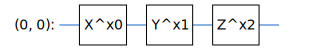

In [21]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

This shows two sections of code defining circuits in a quantum convolutional neural network (QCNN) model. The primary focus here is on defining parameterized one-qubit and two-qubit unitary operations that can be used in the quantum pooling layers of the QCNN. Let’s go through each part in detail.

***1. One-Qubit Unitary Circuit***

The first circuit displayed is the output of the `one_qubit_unitary` function, which represents a parameterized one-qubit unitary operation. This is a foundational component in quantum convolution and pooling operations.

- **Structure**:
  - The circuit consists of three parameterized rotation gates: \( X^{x0} \), \( Y^{x1} \), and \( Z^{x2} \).
  - These gates are controlled by three separate parameters (`x0`, `x1`, and `x2`), allowing the one-qubit gate to be tuned during training.

- **Purpose**:
  - This one-qubit unitary is flexible, enabling the QCNN model to learn an optimal transformation for each qubit during training.
  - By applying rotations along different axes (X, Y, and Z), this circuit can represent any arbitrary one-qubit transformation. This is essential for encoding and manipulating information in each qubit.

***2. Two-Qubit Pooling Operation***

The code also defines a `two_qubit_pool` function, which constructs a parameterized *quantum pooling operation* using two qubits (`source_qubit` and `sink_qubit`). Pooling is essential in a QCNN to reduce the qubit count, similar to how pooling in classical CNNs reduces the dimensionality of feature maps.

- **Structure**:
  - The two-qubit pooling operation begins by applying a parameterized one-qubit unitary transformation on each qubit using the `one_qubit_unitary` function.
  - The **`CNOT` gate** is then applied with `source_qubit` as the control and `sink_qubit` as the target, creating an entanglement between the two qubits. This gate helps transfer information between the qubits in a controlled manner.
  - The **inverse of the sink basis selector** is then applied to `sink_qubit` to "undo" the initial operation, isolating the impact of the pooling operation on `source_qubit`.

- **Purpose**:
  - This pooling operation reduces entanglement by selectively retaining information from the `source_qubit` and partially "resetting" the `sink_qubit`.
  - The use of parameterized one-qubit gates, along with the entangling CNOT gate, allows the pooling operation to adapt based on training, potentially discarding less relevant information from one of the qubits while preserving useful features in the other.

***Summary***

- **One-Qubit Unitary**: A parameterized circuit with three rotation gates (X, Y, Z) that allows each qubit to undergo a flexible transformation. This enables the model to adjust each qubit’s state based on learned parameters.
  
- **Two-Qubit Pooling Operation**:
  - A parameterized circuit that operates on a pair of qubits.
  - It applies transformations to each qubit, entangles them with a CNOT gate, and uses an inverse operation to reduce entanglement selectively.
  - This operation reduces the number of qubits in the QCNN, pooling information to focus on key features while discarding less relevant information.

These circuits form the building blocks of the QCNN’s quantum convolution and pooling layers, allowing it to process and reduce the dimensionality of quantum data in a flexible, trainable way.

And the two-qubit unitary circuit:

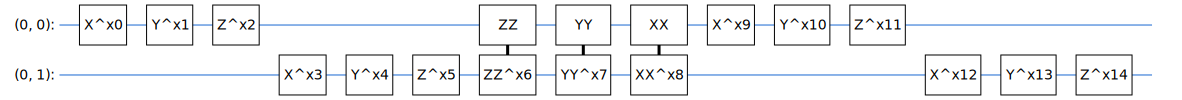

In [22]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

This shows a quantum circuit representing a two-qubit parameterized unitary operation, with a mix of single-qubit and two-qubit gates applied in sequence to two qubits `(0, 0)` and `(0, 1)`. This circuit is intended for use in a Quantum Convolutional Neural Network (QCNN), where such parameterized circuits play a crucial role in pooling and entangling qubits. Let’s break down the components of this circuit.

***Overview of the Circuit***

The circuit includes:
1. **Parameterized Single-Qubit Rotations (X, Y, Z Gates)**:
   - Applied independently on each qubit to allow for flexible transformations controlled by parameters.
2. **Parameterized Two-Qubit Gates (ZZ, YY, XX Gates)**:
   - Applied between the two qubits, creating entanglement and interactions based on adjustable parameters.

***Detailed Breakdown***

1. **Single-Qubit Gates on `(0, 0)` and `(0, 1)`**:
   - The circuit starts with parameterized single-qubit gates (`X`, `Y`, `Z`) applied to each qubit. These are indicated by symbols such as `X^x0`, `Y^x1`, and `Z^x2`.
   - These gates allow each qubit’s state to be independently rotated around the X, Y, and Z axes, with parameters controlling the extent of each rotation.
   - These single-qubit rotations prepare the individual qubits for the two-qubit operations that follow.

2. **Two-Qubit Gates (ZZ, YY, XX)**:
   - The circuit includes several two-qubit gates, each parameterized and entangling the qubits in specific ways:
     - **ZZ Gate**: Represents a controlled rotation between the two qubits around the Z axis, indicated as `ZZ^x4`.
     - **YY Gate**: Represents a controlled rotation around the Y axis, indicated as `YY^x5`.
     - **XX Gate**: Represents a controlled rotation around the X axis, indicated as `XX^x6`.
   - These two-qubit gates are applied with parameters to tune the entangling strength, allowing for adaptive interactions between the qubits during training.
   - The use of multiple two-qubit gates with different axes of control (Z, Y, X) provides a richer set of interactions between qubits, enabling the circuit to capture complex entangled states.

3. **Additional Single-Qubit Gates**:
   - After the two-qubit interactions, further single-qubit `X`, `Y`, and `Z` gates are applied to each qubit with additional parameters, allowing for final rotations.
   - These additional single-qubit gates provide further control over each qubit’s state after entangling interactions, helping to encode information more effectively.

***Purpose of the Circuit***

This two-qubit parameterized circuit is likely used for pooling or encoding operations within a QCNN. Here’s how it contributes to the overall QCNN architecture:

- **Flexible Transformation and Entanglement**:
  - The circuit includes a series of parameterized operations that can be adjusted during training, making it possible for the network to learn useful transformations and patterns within the quantum data.
  - The combination of single- and two-qubit gates allows the model to entangle and disentangle the qubits as needed, essential for reducing dimensionality in pooling layers.
  
- **Learnable Parameters**:
  - Each gate in this circuit has a learnable parameter, enabling the model to adapt the transformation and entanglement strength based on the data. This makes the circuit flexible and adaptable to the task at hand.

- **Pooling or Feature Extraction**:
  - In the context of a QCNN, this two-qubit unitary could be part of a pooling layer, where information from two qubits is combined or simplified into a lower-dimensional representation. This reduces the number of qubits while preserving key information.

***Summary***

This circuit is a sophisticated two-qubit parameterized unitary operation, featuring a combination of single-qubit rotations and entangling two-qubit gates. Each gate is controlled by a parameter, allowing the circuit to learn and adapt based on training data. This circuit can be used as part of a quantum pooling layer in a QCNN, helping reduce the complexity of the quantum state by pooling information from two qubits into one while maintaining critical features.

And the two-qubit pooling circuit:

In [ ]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

This shows a two-qubit quantum circuit designed for use in a Quantum Convolutional Neural Network (QCNN). This circuit appears to be a pooling layer that operates on two qubits labeled `(0, 0)` and `(0, 1)`, where parameterized single-qubit and two-qubit gates are applied in sequence. Let’s go through each part of this circuit step-by-step.

***Circuit Components and Structure***

1. **Parameterized Single-Qubit Gates on Qubits `(0, 0)` and `(0, 1)`**:
   - The circuit begins with three parameterized single-qubit rotation gates applied to each qubit:
     - On qubit `(0, 0)`:
       - `X^x0`, `Y^x1`, `Z^x2` indicate rotations around the X, Y, and Z axes, controlled by parameters `x0`, `x1`, and `x2`.
     - On qubit `(0, 1)`:
       - `X^x3`, `Y^x4`, `Z^x5` similarly represent rotations around each axis with parameters `x3`, `x4`, and `x5`.
   - These parameterized single-qubit rotations allow the model to adjust each qubit’s state individually based on the training data. By applying rotations around different axes, these gates enable a wide range of possible transformations for each qubit.

2. **Two-Qubit CNOT Gate**:
   - After the initial single-qubit rotations, a CNOT (controlled-NOT) gate is applied with qubit `(0, 0)` as the control and qubit `(0, 1)` as the target.
   - The CNOT gate creates an entanglement between the two qubits, depending on the state of the control qubit. This entanglement is crucial for pooling operations, as it allows information to be transferred and shared between the qubits.
   - In the context of a QCNN, this CNOT gate allows the two qubits to interact, enabling the circuit to perform more complex operations that depend on the combined state of both qubits.

3. **Inverse Rotations on Qubit `(0, 1)`**:
   - After the CNOT gate, the circuit applies a set of rotations with negative exponents on qubit `(0, 1)`, effectively acting as inverse operations to undo the original transformations applied at the start of the circuit.
     - These inverse operations are:
       - `Z^-x2`, `Y^-x1`, and `X^-x0`.
   - These inverse gates "cancel out" the effect of the initial single-qubit rotations on qubit `(0, 1)`. This selective reset allows the circuit to retain the impact of the entangling CNOT gate on qubit `(0, 0)`, effectively "pooling" information into a single qubit by preserving relevant transformations.

***Purpose and Function of the Circuit***

This two-qubit pooling circuit performs several key functions in the context of a QCNN:

- **Pooling Operation**:
  - The purpose of pooling in QCNNs is to reduce the number of qubits while retaining essential information. This is similar to how pooling in classical CNNs reduces spatial dimensions while preserving important features.
  - By using inverse rotations on one of the qubits, the circuit effectively resets it while retaining the entangled information on the other qubit. This reduces dimensionality in a controlled manner, allowing for efficient data compression.

- **Parameterization and Learnability**:
  - The parameters (`x0` through `x5`) provide flexibility, allowing the circuit to adapt during training. The model can optimize these parameters to maximize performance on a given task.
  - The presence of parameterized gates makes the circuit highly adaptable, as it can learn optimal rotations for feature extraction based on the input data.

- **Entanglement and Information Transfer**:
  - The CNOT gate entangles the two qubits, transferring information between them. Combined with the subsequent reset of one qubit, this circuit structure enables the model to capture interactions between qubits effectively and retain useful features in a reduced form.

***Summary***

- **Single-Qubit Gates**: The initial parameterized rotations allow each qubit to undergo a unique transformation, creating a wide variety of possible quantum states.
- **CNOT Gate**: The CNOT gate entangles the two qubits, facilitating interaction and shared information.
- **Inverse Rotations**: The final set of inverse rotations "cancels out" transformations on one qubit, enabling a selective reset that retains information in the other qubit, achieving a pooling effect.

This circuit serves as a two-qubit pooling layer in a QCNN, enabling dimensionality reduction while preserving critical features through entanglement and selective resetting. The combination of learnable parameters and entangling operations allows the QCNN to effectively process quantum data and retain meaningful patterns for classification or other quantum machine learning tasks.

#### Quantum Convolution

As in the <a href="https://arxiv.org/abs/1810.03787" class="external">Cong and Lukin</a> paper, define the 1D quantum convolution as the application of a two-qubit parameterized unitary to every pair of adjacent qubits with a stride of one.

In [23]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """

    circuit = cirq.Circuit()

    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)

    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)

    return circuit

Display the (very horizontal) circuit:

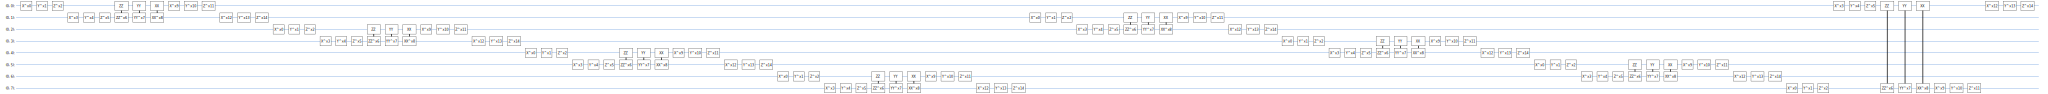

In [24]:
SVGCircuit(quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

#### Quantum Pooling

A quantum pooling layer pools from $N$ qubits to $\frac{N}{2}$ qubits using the two-qubit pool defined above.

In [25]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """

    circuit = cirq.Circuit()

    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)

    return circuit

Examine a pooling component circuit:

In [26]:
test_bits = cirq.GridQubit.rect(1, 8)

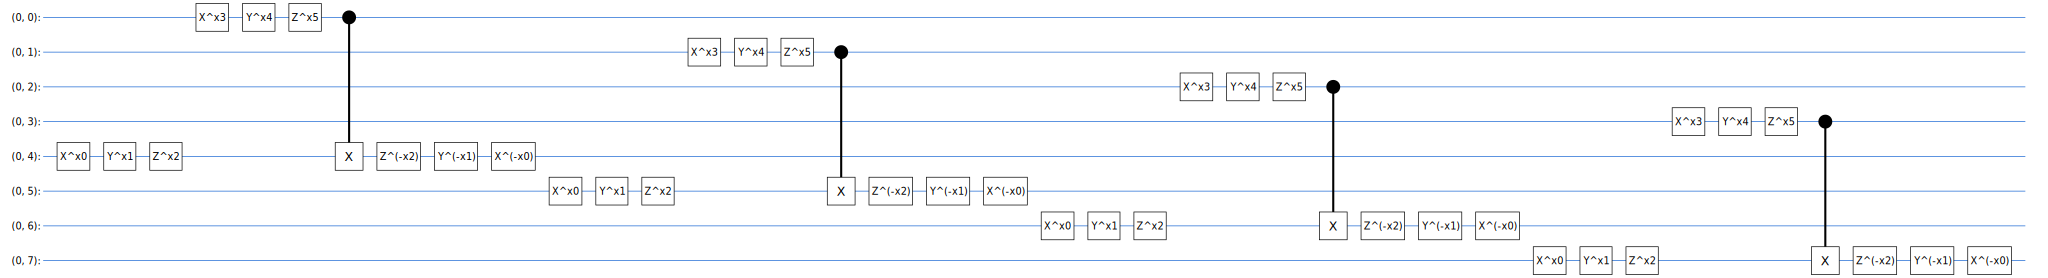

In [27]:
SVGCircuit(quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))

This displays a multi-layer quantum circuit, designed to serve as a *quantum pooling layer* within a Quantum Convolutional Neural Network (QCNN). The circuit appears to have eight qubits, each undergoing a series of parameterized single-qubit rotations, two-qubit gates, and controlled operations. This structure aligns with the general purpose of QCNNs, which is to perform feature extraction and dimensionality reduction in quantum data, similar to pooling and convolution operations in classical CNNs. Let's analyze this circuit layer by layer.

***Structure and Components of the Circuit***

1. **Single-Qubit Parameterized Rotations**:
   - Each qubit in the circuit begins with a series of parameterized single-qubit rotation gates: `X`, `Y`, and `Z` gates.
   - For example, qubit `(0, 0)` has `X^x0`, `Y^x1`, and `Z^x2`, where `x0`, `x1`, and `x2` are parameters. These rotations are tunable, allowing the model to adjust the initial state of each qubit based on the input data.
   - These parameterized rotations allow each qubit’s state to be transformed independently, setting up the qubits for further interaction.

2. **Two-Qubit Controlled Gates (CNOTs)**:
   - After the single-qubit operations, controlled gates (specifically CNOT gates) are applied between neighboring qubits.
   - For instance:
     - The CNOT gate between qubits `(0, 0)` and `(0, 1)` has `(0, 0)` as the control and `(0, 1)` as the target.
     - Similarly, CNOT gates are placed between pairs `(0, 2)` and `(0, 3)`, `(0, 4)` and `(0, 5)`, and `(0, 6)` and `(0, 7)`.
   - These CNOT gates create entanglement between neighboring qubits, allowing the qubits to share information and interact in ways that are crucial for feature extraction.

3. **Additional Single-Qubit Parameterized Gates**:
   - Following the CNOT gates, each qubit has another series of parameterized rotations (`X`, `Y`, `Z`), with negative exponents for some gates, such as `X^-x0`, `Y^-x1`, and `Z^-x2`.
   - These additional single-qubit operations can either refine or partially undo the initial transformations on each qubit. This selective resetting is used to control the qubit states after the interaction in the CNOT gates, effectively "pooling" information by preserving only certain aspects of each qubit’s transformation.

4. **Pooling Structure**:
   - The pooling structure of this circuit becomes evident through the combination of entangling (CNOT) gates and selective single-qubit transformations.
   - By entangling pairs of qubits and then applying inverse transformations on some qubits, the circuit is able to selectively reset certain qubits while keeping entangled information on others. This operation effectively reduces the dimensionality of the data, as some qubits are "pooled" or "reset" to a simplified state.

***Purpose of the Circuit in QCNN***

This circuit layer is specifically designed for the pooling stage of a QCNN, which serves to reduce the number of qubits while preserving essential information. Here’s a breakdown of how it achieves this:

- **Feature Extraction via Entanglement**:
  - The CNOT gates entangle pairs of qubits, allowing complex patterns and relationships in the quantum state to be captured. This process is akin to how convolution layers in classical CNNs capture spatial features through filters.
  
- **Dimensionality Reduction via Selective Reset**:
  - After the entanglement step, the circuit selectively applies inverse transformations on certain qubits, which helps reset or reduce the information stored in them. This selective reset retains relevant features in specific qubits, reducing the overall complexity of the data.
  - By only keeping the essential information in fewer qubits, the circuit performs a pooling operation, reducing the dimensionality of the data in a way that retains critical information for further processing.

- **Learnability through Parameterized Gates**:
  - Each gate in the circuit has a parameter, making this layer highly adaptable. During training, these parameters can be optimized to learn the best transformations for capturing and retaining the most relevant features.
  - The learnable parameters allow the QCNN model to adapt to different quantum data inputs, making it more flexible and powerful for classification or other machine learning tasks.

***Summary***

This circuit is a quantum pooling layer for a QCNN, structured as follows:

- **Initial Parameterized Rotations**: Each qubit undergoes single-qubit rotations (X, Y, Z) with tunable parameters.
- **Entangling (CNOT) Gates**: CNOT gates between qubit pairs create entanglement, capturing relationships between neighboring qubits.
- **Selective Inverse Rotations**: Inverse single-qubit rotations selectively reset certain qubits, performing dimensionality reduction by preserving key information in a subset of qubits.

This quantum pooling circuit effectively reduces the complexity of the quantum state while preserving important features, allowing the QCNN to process quantum data in a structured and efficient way for downstream tasks.

## Model definition

Now use the defined layers to construct a purely quantum CNN. Start with eight qubits, pool down to one, then measure $\langle \hat{Z} \rangle$.

In [28]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators
    which gradually shrink over time."""

    model_circuit = cirq.Circuit()

    symbols = sympy.symbols('qconv0:63')

    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.

    model_circuit += quantum_conv_circuit(qubits,
                                          symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4],
                                          qubits[4:],
                                          symbols[15:21])

    model_circuit += quantum_conv_circuit(qubits[4:],
                                          symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[4:6],
                                          qubits[6:],
                                          symbols[36:42])

    model_circuit += quantum_conv_circuit(qubits[6:],
                                          symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[6]],[qubits[7]],
                                          symbols[57:63])

    return model_circuit

In [29]:
# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

In [30]:
# Build a sequential model enacting the logic in 1.3 of this notebook.
# Here you are making the static cluster state prep as a part of the AddCircuit and the
# "quantum datapoints" are coming in the form of excitation
excitation_input = tf.keras.Input(shape=(),
                                  dtype=tf.dtypes.string)

cluster_state = tfq.layers.AddCircuit()(excitation_input,
                                        prepend=cluster_state_circuit(cluster_state_bits))

In [31]:
quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),readout_operators)(cluster_state)

In [32]:
qcnn_model = tf.keras.Model(inputs = [excitation_input],
                            outputs = [quantum_model])

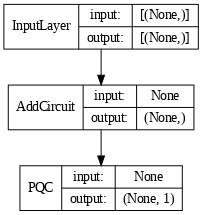

In [33]:
# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

This shows a simple *quantum-classical hybrid model architecture* built using TensorFlow Quantum. It consists of three main layers: an `InputLayer`, an `AddCircuit` layer, and a `PQC` (Parameterized Quantum Circuit) layer. Here's an explanation of each layer and its role in the model:

***1. InputLayer***

- **Description**: The `InputLayer` is the starting point of the model, defining the shape and type of data that the model will accept.
- **Input Shape**: `[(None,)]` indicates that the model can accept a batch of quantum circuits as input. `None` represents the batch size, which is flexible and can be determined during runtime.
- **Output Shape**: `[(None,)]` means that the input is passed through unchanged, preparing it for the next layer.
- **Purpose**: This layer takes in quantum data (represented as circuit tensors) and provides a structured input for further quantum processing.

***2. AddCircuit Layer***

- **Description**: The `AddCircuit` layer is a layer in TensorFlow Quantum that allows you to append or prepend a predefined quantum circuit to each input circuit.
- **Input Shape**: `None`, indicating that the input here is a batch of circuits.
- **Output Shape**: `[(None,)]`, meaning that the output is still a batch of circuits with the added circuit embedded.
- **Purpose**: This layer is used to apply a fixed quantum circuit (such as a cluster state preparation or some other initial circuit) to each input circuit. This fixed circuit serves as a foundational structure or initial state for further quantum operations. For example, in a quantum convolutional neural network (QCNN), it might be used to prepare a specific cluster state.

***3. PQC (Parameterized Quantum Circuit) Layer***

- **Description**: The `PQC` layer in TensorFlow Quantum is a layer that takes a parameterized quantum circuit and outputs the expectation value of an observable, such as the Pauli-Z operator. This layer enables the model to perform a final measurement on the quantum circuit and produce a classical output.
- **Input Shape**: `None`, as it accepts a batch of circuits (now modified by the `AddCircuit` layer).
- **Output Shape**: `[(None, 1)]`, indicating that the output is a batch of single scalar values (one for each circuit).
- **Purpose**: This layer performs the final inference step by measuring the expectation value of a chosen observable (like ⟨Z⟩). The result of this measurement is used as the output of the model, which is typically a single value indicating the classification or prediction result.

***Overall Model Purpose***

This model architecture represents a straightforward quantum-classical hybrid model, where the input is a quantum circuit, and the output is a single classical scalar value. Here’s how it functions in the context of a quantum machine learning task:

1. **Input Preparation**: The `InputLayer` accepts quantum circuits as inputs.
2. **Embedding a Fixed Circuit**: The `AddCircuit` layer appends or prepends a fixed quantum circuit (such as a cluster state preparation or quantum feature extraction circuit) to each input, ensuring each circuit starts from a standardized initial state.
3. **Quantum Inference and Measurement**: The `PQC` layer performs the final measurement on each circuit, producing a classical output. This output can be used for tasks like binary classification, where the model determines whether a quantum state belongs to one of two categories.

This architecture is suitable for quantum machine learning tasks where quantum data is processed through a fixed initial state, followed by parameterized operations that allow for flexible learning, and finally measured to produce a classical prediction. The simplicity of this model makes it efficient for tasks that require a hybrid quantum-classical approach.

## Train the model

Train the model over the full batch to simplify this example.

In [34]:
# Generate some training data.
train_excitations, train_labels, test_excitations, test_labels = generate_data(cluster_state_bits)

In [35]:
# Custom accuracy metric.
@tf.function

def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0,
                       y_pred)

    return tf.keras.backend.mean(tf.keras.backend.equal(y_true,
                                                        y_pred))

In [36]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

In [37]:
history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

Epoch 1/25
7/7 [==============================] - 3s 192ms/step - loss: 0.8757 - custom_accuracy: 0.7946 - val_loss: 0.8258 - val_custom_accuracy: 0.7500
Epoch 2/25
7/7 [==============================] - 1s 133ms/step - loss: 0.8317 - custom_accuracy: 0.8393 - val_loss: 0.7437 - val_custom_accuracy: 0.7917
Epoch 3/25
7/7 [==============================] - 1s 133ms/step - loss: 0.7766 - custom_accuracy: 0.7768 - val_loss: 0.7147 - val_custom_accuracy: 0.7292
Epoch 4/25
7/7 [==============================] - 1s 157ms/step - loss: 0.7660 - custom_accuracy: 0.7857 - val_loss: 0.7248 - val_custom_accuracy: 0.7500
Epoch 5/25
7/7 [==============================] - 1s 129ms/step - loss: 0.7543 - custom_accuracy: 0.7946 - val_loss: 0.6993 - val_custom_accuracy: 0.8125
Epoch 6/25
7/7 [==============================] - 1s 133ms/step - loss: 0.7219 - custom_accuracy: 0.8304 - val_loss: 0.6558 - val_custom_accuracy: 0.7917
Epoch 7/25
7/7 [==============================] - 1s 159ms/step - loss: 0.64

This output shows the training and validation results for the 25th (final) epoch of a quantum-classical hybrid model training in TensorFlow. Let's break down each component:

1. **Epoch 25/25**:
   - This indicates that the model is currently at the 25th and final epoch of training. An epoch is one full cycle through the entire training dataset, and the model was set to train for a total of 25 epochs.

2. **7/7 [==============================] - 1s 132ms/step**:
   - **7/7**: This shows that there are 7 batches in each epoch, and all 7 batches have been processed for this epoch.
   - **1s**: The total time taken to complete this epoch was approximately 1 second.
   - **132ms/step**: This indicates the average time per batch (step), which is 132 milliseconds.

3. **Loss and Accuracy Metrics**:
   - **loss: 0.5364**: This is the training loss at the end of the 25th epoch, calculated on the training dataset. A lower loss generally indicates better performance in terms of the model’s fit to the training data.
   - **custom_accuracy: 0.8929**: This is the training accuracy for the 25th epoch, reported using a custom accuracy metric. It shows that the model achieved an accuracy of 89.29% on the training data in this epoch.

4. **Validation Loss and Accuracy Metrics**:
   - **val_loss: 0.5856**: This is the validation loss at the end of the 25th epoch, calculated on the validation dataset. It indicates how well the model is performing on unseen data. A higher validation loss compared to the training loss may suggest slight overfitting, but the difference here is minimal.
   - **val_custom_accuracy: 0.8958**: This is the validation accuracy using the custom accuracy metric, calculated on the validation dataset. The model achieved an accuracy of 89.58% on the validation data in this epoch, which is comparable to the training accuracy, indicating that the model generalizes well.

***Summary***

At the end of 25 epochs:
- The model has a **training loss of 0.5364** and a **training accuracy of 89.29%**.
- On the validation data, the model achieved a **validation loss of 0.5856** and a **validation accuracy of 89.58%**.

These metrics suggest that the model has learned to classify or predict well, with similar performance on both training and validation data, indicating that it is not overfitting and generalizes effectively to unseen data.

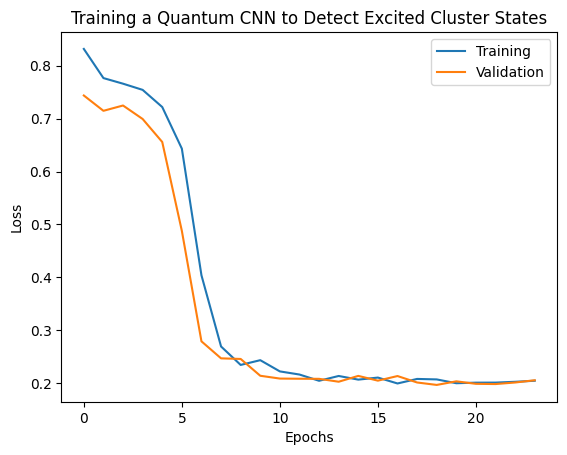

In [38]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This plot shows the loss values for both the training and validation datasets over the course of training epochs for a Quantum Convolutional Neural Network (QCNN) model. The model is being trained to detect "excited" cluster states, and the loss values are used as a measure of how well the model fits the data. Here’s a detailed breakdown:

***Plot Components***

1. **Axes**:
   - **X-axis (Epochs)**: This represents the training epochs, ranging from 0 to 25. Each epoch corresponds to one full pass through the training dataset.
   - **Y-axis (Loss)**: This represents the loss value. Loss is a measure of the model’s error; lower loss indicates better model performance on the respective dataset (training or validation).

2. **Curves**:
   - **Blue Line (Training Loss)**: This line shows the loss on the training dataset over each epoch.
   - **Orange Line (Validation Loss)**: This line shows the loss on the validation dataset, which is an unseen portion of data used to assess how well the model generalizes.

***Observations***

1. **Decreasing Loss**:
   - Both the training and validation loss decrease over time, indicating that the model is learning and improving its performance as training progresses.
   - The training loss (blue line) decreases steadily, showing that the model is gradually fitting the training data better with each epoch.
   - The validation loss (orange line) also decreases, but it fluctuates a bit more than the training loss, which is typical as validation data helps assess how well the model generalizes to unseen data.

2. **Convergence**:
   - By the end of training (around 25 epochs), both the training and validation loss values converge close to each other, indicating that the model performs similarly on both datasets.
   - The fact that the validation loss is close to the training loss suggests that the model is not overfitting. Overfitting would typically show a large gap between training and validation losses, with training loss decreasing while validation loss remains high or starts to increase.

3. **Generalization**:
   - The validation loss remains consistently close to the training loss, which is a good sign of generalization. This indicates that the model can generalize its learning to new data (validation data in this case) and is not just memorizing the training data.

***Summary***

The plot demonstrates that the Quantum CNN model is learning effectively, as indicated by the decreasing training and validation losses. Both losses converge to similar values by the end of training, suggesting that the model is well-regularized and generalizes well to unseen data. This is a positive indication that the model has effectively learned to detect excited cluster states without overfitting.

# Hybrid models

You don't have to go from eight qubits to one qubit using quantum convolution—you could have done one or two rounds of quantum convolution and fed the results into a classical neural network. This section explores quantum-classical hybrid models.

## Hybrid model with a single quantum filter

Apply one layer of quantum convolution, reading out $\langle \hat{Z}_n \rangle$ on all bits, followed by a densely-connected neural network.

<img src="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/images/qcnn_5.png?raw=1" width="1000">

### Model Definition

In [39]:
# 1-local operators to read out
readouts = [cirq.Z(bit) for bit in cluster_state_bits[4:]]

In [40]:
def multi_readout_model_circuit(qubits):
    """Make a model circuit with less quantum pool and conv operations."""

    model_circuit = cirq.Circuit()

    symbols = sympy.symbols('qconv0:21')

    model_circuit += quantum_conv_circuit(qubits,
                                          symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4],
                                          qubits[4:],
                                          symbols[15:21])

    return model_circuit

In [41]:
# Build a model enacting the logic in 2.1 of this notebook.
excitation_input_dual = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

In [42]:
cluster_state_dual = tfq.layers.AddCircuit()(excitation_input_dual,
                                             prepend=cluster_state_circuit(cluster_state_bits))

In [43]:
quantum_model_dual = tfq.layers.PQC(multi_readout_model_circuit(cluster_state_bits),readouts)(cluster_state_dual)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [44]:
d1_dual = tf.keras.layers.Dense(8)(quantum_model_dual)

d2_dual = tf.keras.layers.Dense(1)(d1_dual)

In [45]:
hybrid_model = tf.keras.Model(inputs=[excitation_input_dual],
                              outputs=[d2_dual])

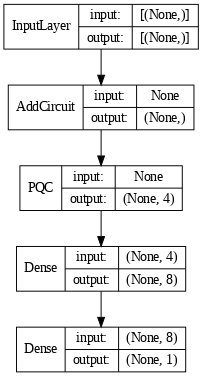

In [46]:
# Display the model architecture
tf.keras.utils.plot_model(hybrid_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

This image shows a *quantum-classical hybrid neural network architecture* that combines quantum processing layers with classical fully connected (dense) layers. The architecture includes an `InputLayer`, an `AddCircuit` layer, a `PQC` (Parameterized Quantum Circuit) layer, and two dense (fully connected) layers. Here’s a detailed breakdown of each layer and its role in the model:

***1. InputLayer***

- **Description**: This is the starting layer of the model, which defines the shape and type of data the model will receive.
- **Input Shape**: `[(None,)]`, indicating that the input is a batch of quantum circuits, where `None` represents a flexible batch size.
- **Output Shape**: `[(None,)]`, meaning that the data shape is unchanged as it passes to the next layer.
- **Purpose**: This layer accepts quantum circuit inputs, which will be processed by quantum components in subsequent layers.

***2. AddCircuit Layer***

- **Description**: This layer appends or prepends a predefined quantum circuit to each input circuit. It is commonly used in TensorFlow Quantum to embed a fixed quantum operation to prepare a specific state.
- **Input Shape**: `None`, as the input is a batch of circuits.
- **Output Shape**: `[(None,)]`, meaning the output remains a batch of circuits, now with the predefined circuit added.
- **Purpose**: This layer could be used to add a cluster state or some other standard quantum state as a base for further quantum transformations in the model. This provides a consistent starting state across all inputs.

***3. PQC (Parameterized Quantum Circuit) Layer***

- **Description**: The PQC layer in TensorFlow Quantum applies a parameterized quantum circuit to each input and measures specific observables to produce a classical output.
- **Input Shape**: `None`, as it receives a batch of quantum circuits from the `AddCircuit` layer.
- **Output Shape**: `[(None, 4)]`, indicating that the layer outputs a batch of 4-dimensional vectors, where each dimension is a measured expectation value from the quantum circuit.
- **Purpose**: This layer performs the quantum computation and outputs classical values (expectation values) that summarize the quantum state in a way that can be used by classical layers. These 4-dimensional outputs serve as features for the classical part of the model.

***4. First Dense Layer***

- **Description**: This is a classical fully connected (dense) layer that processes the 4-dimensional outputs from the PQC layer.
- **Input Shape**: `[(None, 4)]`, representing the 4-dimensional vector output from each quantum circuit in the batch.
- **Output Shape**: `[(None, 8)]`, meaning that this layer transforms the input into an 8-dimensional vector for each sample.
- **Purpose**: This dense layer acts as a feature transformation layer, allowing the model to learn relationships within the 4-dimensional outputs from the PQC layer and expand the representation to 8 dimensions.

***5. Second Dense Layer (Output Layer)***

- **Description**: This is another fully connected layer that reduces the dimensionality of the output to a single value, making it suitable for binary classification or regression.
- **Input Shape**: `[(None, 8)]`, the 8-dimensional output from the previous dense layer.
- **Output Shape**: `[(None, 1)]`, providing a single output value for each sample in the batch.
- **Purpose**: This layer produces the final output, which could represent a binary classification (e.g., detecting an "excited" state vs. a "non-excited" state) or a regression output, depending on the task.

***Overall Model Purpose***

This hybrid model structure integrates quantum computation with classical processing, taking advantage of both quantum feature extraction and classical neural network layers. Here’s how it functions in the context of a quantum machine learning task:

1. **Quantum Processing**: The `AddCircuit` and `PQC` layers handle the quantum part of the model. The `AddCircuit` layer embeds a fixed quantum circuit as a starting point, and the `PQC` layer applies a parameterized quantum circuit to extract features from the quantum data, outputting classical values.
  
2. **Classical Processing**: The dense layers process the classical output from the PQC layer, enabling the model to learn complex relationships and generate predictions. These layers handle feature transformation and final output.

This architecture is ideal for tasks where quantum data needs to be processed, and classical layers can refine the quantum-derived features to make a final prediction, such as detecting specific states or classifying quantum data. The model combines the strengths of both quantum and classical processing, making it powerful and adaptable for quantum machine learning applications.

### Train the model

In [47]:
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                     loss=tf.losses.mse,
                     metrics=[custom_accuracy])

In [48]:
hybrid_history = hybrid_model.fit(x=train_excitations,
                                  y=train_labels,
                                  batch_size=16,
                                  epochs=25,
                                  verbose=1,
                                  validation_data=(test_excitations,
                                                   test_labels))

Epoch 1/25
7/7 [==============================] - 2s 117ms/step - loss: 1.0028 - custom_accuracy: 0.5268 - val_loss: 1.0371 - val_custom_accuracy: 0.4583
Epoch 2/25
7/7 [==============================] - 1s 86ms/step - loss: 0.7892 - custom_accuracy: 0.6696 - val_loss: 0.5905 - val_custom_accuracy: 0.8125
Epoch 3/25
7/7 [==============================] - 1s 82ms/step - loss: 0.4081 - custom_accuracy: 0.8482 - val_loss: 0.4310 - val_custom_accuracy: 0.9167
Epoch 4/25
7/7 [==============================] - 1s 129ms/step - loss: 0.2992 - custom_accuracy: 0.9554 - val_loss: 0.2321 - val_custom_accuracy: 0.9792
Epoch 5/25
7/7 [==============================] - 1s 143ms/step - loss: 0.1957 - custom_accuracy: 0.9732 - val_loss: 0.1992 - val_custom_accuracy: 0.9375
Epoch 6/25
7/7 [==============================] - 1s 148ms/step - loss: 0.1656 - custom_accuracy: 1.0000 - val_loss: 0.1578 - val_custom_accuracy: 0.9792
Epoch 7/25
7/7 [==============================] - 1s 103ms/step - loss: 0.1781

This output shows the training and validation results for the 25th (final) epoch of a model's training process in TensorFlow. Here’s a breakdown of each component:

1. **Epoch 25/25**:
   - This indicates that the model is currently at the 25th and final epoch of training. An epoch is one full pass through the entire training dataset. In this case, the model was set to train for a total of 25 epochs.

2. **7/7 [==============================] - 1s 82ms/step**:
   - **7/7**: This shows that there are 7 batches in each epoch, and all 7 batches have been processed for this epoch.
   - **1s**: The total time taken to complete this epoch was approximately 1 second.
   - **82ms/step**: This is the average time per batch (step), which is 82 milliseconds.

3. **Loss and Accuracy Metrics**:
   - **loss: 0.2064**: This is the training loss at the end of the 25th epoch, calculated on the training dataset. A lower loss generally indicates better performance in terms of the model’s fit to the training data.
   - **custom_accuracy: 0.9732**: This is the training accuracy for the 25th epoch, reported using a custom accuracy metric. It shows that the model achieved an accuracy of 97.32% on the training data in this epoch.

4. **Validation Loss and Accuracy Metrics**:
   - **val_loss: 0.2517**: This is the validation loss at the end of the 25th epoch, calculated on the validation dataset. The validation loss is slightly higher than the training loss, which is typical and often indicates that the model is generalizing well. However, if the validation loss were much higher, it could suggest overfitting.
   - **val_custom_accuracy: 0.9583**: This is the validation accuracy, calculated on the validation dataset using the same custom accuracy metric. The model achieved an accuracy of 95.83% on the validation data, which is close to the training accuracy, indicating good generalization.

***Summary***

At the end of the 25th epoch:
- The model has a **training loss of 0.2064** and a **training accuracy of 97.32%**.
- On the validation data, the model achieved a **validation loss of 0.2517** and a **validation accuracy of 95.83%**.

These results indicate that the model is performing well:
- **High accuracy** on both training and validation datasets suggests that the model is effectively learning the patterns in the data.
- **Low loss values** for both training and validation datasets indicate that the model’s predictions are close to the actual labels, and the model is well-optimized.
- **Comparable training and validation accuracy** suggests that the model is generalizing well to new data and is not overfitting.

Overall, this output indicates successful training with strong model performance on both training and validation datasets.

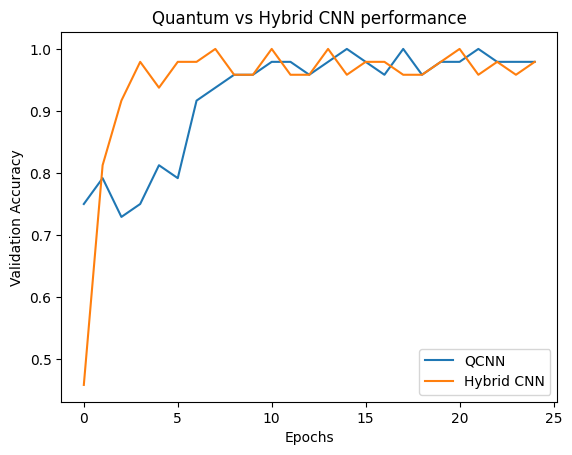

In [49]:
plt.plot(history.history['val_custom_accuracy'], label='QCNN')
plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

This plot compares the **validation accuracy** of two different models—a Quantum Convolutional Neural Network (QCNN) and a Hybrid Convolutional Neural Network (Hybrid CNN)—over 25 training epochs. Here’s a breakdown of the key components and insights from the plot:

***Plot Components***

1. **Axes**:
   - **X-axis (Epochs)**: Represents the number of training epochs, ranging from 0 to 25. Each epoch corresponds to one complete pass through the training data.
   - **Y-axis (Validation Accuracy)**: Represents the accuracy of each model on the validation dataset. Higher accuracy indicates better model performance on unseen data.

2. **Curves**:
   - **Blue Line (QCNN)**: This line represents the validation accuracy of the Quantum Convolutional Neural Network (QCNN) over time.
   - **Orange Line (Hybrid CNN)**: This line shows the validation accuracy of the Hybrid CNN, which is a hybrid quantum-classical model, over time.

***Observations***

1. **Initial Learning Rate**:
   - At the beginning (epochs 0-5), both models start with relatively low accuracy, but they quickly improve over the initial epochs. The Hybrid CNN (orange line) shows a steep increase in accuracy, outperforming the QCNN (blue line) from the start.
   - The Hybrid CNN reaches a high accuracy level by around epoch 5, suggesting that it may have learned the task more quickly than the QCNN.

2. **Stabilization and Performance Comparison**:
   - After about 5 epochs, both models begin to stabilize, with the QCNN’s accuracy leveling off around 85-90% and the Hybrid CNN’s accuracy leveling off around 95-100%.
   - The Hybrid CNN consistently outperforms the QCNN across all epochs. This indicates that the hybrid model may be more effective at capturing and processing the features needed for accurate predictions on this dataset.

3. **Performance Consistency**:
   - The Hybrid CNN maintains high accuracy with minimal fluctuations after it reaches stability, consistently achieving around 95-100% accuracy on the validation set.
   - The QCNN shows minor fluctuations in accuracy across the later epochs, indicating a slightly less stable performance. Its accuracy hovers around 85-90%, suggesting it may be limited in its capacity to fully capture the features needed for peak performance compared to the hybrid model.

***Insights***

- **Hybrid CNN Advantage**: The Hybrid CNN model achieves better validation accuracy and stabilizes at a higher accuracy level than the QCNN. This could be due to the classical layers in the Hybrid CNN, which may provide additional processing power for feature extraction and generalization, combining both quantum and classical strengths.
  
- **QCNN Limitations**: While the QCNN performs well, achieving up to 90% accuracy, it doesn’t reach the same level of accuracy as the Hybrid CNN. This could suggest that, for this specific dataset and task, the pure quantum approach may be limited in its expressiveness or generalization capabilities compared to a hybrid approach.

- **Potential Overfitting Consideration**: The Hybrid CNN’s near-100% accuracy could imply a risk of overfitting if the validation dataset is not sufficiently large or diverse. However, if the validation dataset is representative of the target data, this high accuracy suggests that the Hybrid CNN is very effective for this task.

***Summary***

This plot demonstrates that the Hybrid CNN outperforms the QCNN in terms of validation accuracy, achieving higher and more stable performance across 25 epochs. The Hybrid CNN benefits from both quantum and classical processing, leading to superior feature extraction and generalization. This result highlights the potential of hybrid quantum-classical models to perform better than purely quantum models in certain machine learning tasks.

## Hybrid convolution with multiple quantum filters

Now let's try an architecture that uses multiple quantum convolutions and a classical neural network to combine them.

<img src="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/images/qcnn_6.png?raw=1" width="1000">

### Model Definition

In [50]:
excitation_input_multi = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

In [51]:
cluster_state_multi = tfq.layers.AddCircuit()(excitation_input_multi,
                                              prepend=cluster_state_circuit(cluster_state_bits))

In [52]:
# apply 3 different filters and measure expectation values

quantum_model_multi1 = tfq.layers.PQC(multi_readout_model_circuit(cluster_state_bits), readouts)(cluster_state_multi)

quantum_model_multi2 = tfq.layers.PQC(multi_readout_model_circuit(cluster_state_bits), readouts)(cluster_state_multi)

quantum_model_multi3 = tfq.layers.PQC(multi_readout_model_circuit(cluster_state_bits), readouts)(cluster_state_multi)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values e

In [53]:
# concatenate outputs and feed into a small classical NN
concat_out = tf.keras.layers.concatenate(
    [quantum_model_multi1, quantum_model_multi2, quantum_model_multi3])

dense_1 = tf.keras.layers.Dense(8)(concat_out)

dense_2 = tf.keras.layers.Dense(1)(dense_1)

multi_qconv_model = tf.keras.Model(inputs=[excitation_input_multi],
                                   outputs=[dense_2])

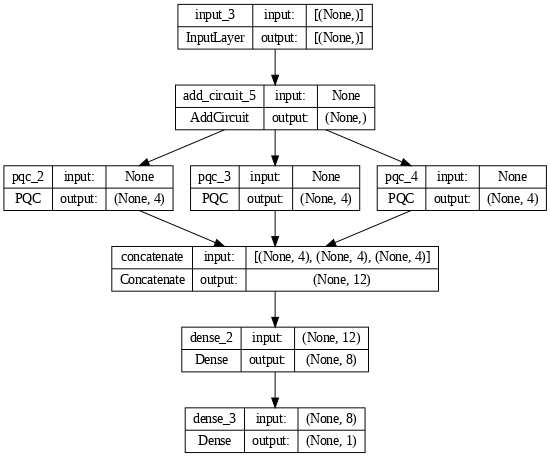

In [54]:
# Display the model architecture
tf.keras.utils.plot_model(multi_qconv_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

This diagram represents a more complex quantum-classical hybrid model architecture, where multiple quantum processing paths are combined before feeding into classical layers. Here’s a breakdown of each component and its role in the model:

***1. Input Layer (`input_3`)***
   - **Type**: `InputLayer`
   - **Input Shape**: `[(None,)]`
   - **Output Shape**: `[(None,)]`
   - **Description**: This is the input layer for the model, which accepts a batch of quantum circuits (represented by TensorFlow Quantum’s circuit tensor format). `None` represents a flexible batch size.

***2. Add Circuit Layer (`add_circuit_5`)***
   - **Type**: `AddCircuit`
   - **Input Shape**: `None`
   - **Output Shape**: `[(None,)]`
   - **Description**: This layer appends a predefined quantum circuit to each input circuit. This circuit could be a specific initial state (like a cluster state) or a fixed quantum transformation that will be applied to all inputs as a starting point.

***3. PQC Layers (`pqc_2`, `pqc_3`, `pqc_4`)***
   - **Type**: `PQC` (Parameterized Quantum Circuit)
   - **Input Shape**: `None`
   - **Output Shape**: `[(None, 4)]` for each `PQC` layer
   - **Description**: These PQC layers apply parameterized quantum circuits on the input data and measure the expectation values of observables, producing classical outputs. Each PQC layer outputs a 4-dimensional vector (presumably from four different measurements or observables in the quantum circuit).
   - **Purpose**: These three parallel PQC layers allow the model to extract multiple quantum features from the input circuit. Each PQC layer might represent a different set of parameterized quantum operations, capturing various aspects of the quantum state.

***4. Concatenate Layer***
   - **Type**: `Concatenate`
   - **Input Shape**: `[(None, 4), (None, 4), (None, 4)]`
   - **Output Shape**: `[(None, 12)]`
   - **Description**: This layer concatenates the outputs from the three PQC layers, resulting in a 12-dimensional vector for each sample in the batch.
   - **Purpose**: By combining the features from all three PQC layers, the model aggregates different quantum feature representations, allowing for a richer feature set to be processed by the classical part of the model.

***5. First Dense Layer (`dense_2`)**
   - **Type**: `Dense`
   - **Input Shape**: `[(None, 12)]`
   - **Output Shape**: `[(None, 8)]`
   - **Description**: This dense layer receives the 12-dimensional concatenated vector and reduces it to an 8-dimensional representation.
   - **Purpose**: This layer acts as a feature transformation layer, enabling the model to learn patterns within the combined quantum features. It helps compress the information while retaining essential features.

***6. Second Dense Layer (`dense_3`)***
   - **Type**: `Dense`
   - **Input Shape**: `[(None, 8)]`
   - **Output Shape**: `[(None, 1)]`
   - **Description**: This is the final dense layer in the model, which reduces the 8-dimensional vector to a single output value for each sample.
   - **Purpose**: This output layer is designed for binary classification (with a single neuron output), where the output value can be interpreted as a probability score for one of two classes. It could also be used for regression tasks if the output is continuous.

***Overall Model Workflow***

1. **Input Preparation**: The input layer receives quantum circuits as inputs.
2. **Circuit Addition**: The `AddCircuit` layer adds a predefined circuit, providing a consistent starting point for all samples.
3. **Quantum Feature Extraction**: Three parallel PQC layers each apply different parameterized quantum circuits, measuring specific observables to extract a 4-dimensional feature vector from each circuit.
4. **Feature Aggregation**: The `Concatenate` layer combines the outputs of the three PQC layers into a single 12-dimensional vector, integrating diverse quantum features.
5. **Classical Processing**: The concatenated quantum features pass through two dense layers, where the model learns relationships among the features and produces a single output for each input sample.

***Purpose of This Model Architecture***

This model structure is well-suited for quantum machine learning tasks where multiple quantum measurements or features are needed to capture the complexity of the data. By using parallel PQC layers, the model can learn a rich representation of the quantum state. The classical dense layers then process these quantum-derived features to make final predictions. This architecture is powerful for tasks requiring detailed quantum feature extraction combined with classical learning techniques, such as classification or regression.

### Train the model

In [55]:
multi_qconv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                          loss=tf.losses.mse,
                          metrics=[custom_accuracy])

In [56]:
multi_qconv_history = multi_qconv_model.fit(x=train_excitations,
                                            y=train_labels,
                                            batch_size=16,
                                            epochs=25,
                                            verbose=1,
                                            validation_data=(test_excitations,
                                                             test_labels))

Epoch 1/25
7/7 [==============================] - 4s 320ms/step - loss: 0.9089 - custom_accuracy: 0.6786 - val_loss: 0.5805 - val_custom_accuracy: 0.9167
Epoch 2/25
7/7 [==============================] - 2s 252ms/step - loss: 0.4198 - custom_accuracy: 0.9107 - val_loss: 0.2086 - val_custom_accuracy: 0.9375
Epoch 3/25
7/7 [==============================] - 1s 206ms/step - loss: 0.2286 - custom_accuracy: 0.9732 - val_loss: 0.1620 - val_custom_accuracy: 0.9792
Epoch 4/25
7/7 [==============================] - 1s 205ms/step - loss: 0.1947 - custom_accuracy: 0.9464 - val_loss: 0.1893 - val_custom_accuracy: 0.9583
Epoch 5/25
7/7 [==============================] - 1s 209ms/step - loss: 0.1808 - custom_accuracy: 0.9732 - val_loss: 0.2422 - val_custom_accuracy: 0.9583
Epoch 6/25
7/7 [==============================] - 1s 209ms/step - loss: 0.2012 - custom_accuracy: 0.9732 - val_loss: 0.2123 - val_custom_accuracy: 0.9583
Epoch 7/25
7/7 [==============================] - 2s 244ms/step - loss: 0.18

This output shows the results of the 25th and final epoch of training for a quantum-classical hybrid model. Here’s a detailed explanation of each component:

1. **Epoch 25/25**:
   - This indicates that the model is on the 25th and last epoch of training. An epoch is one complete pass through the training dataset, and the model was set to train for a total of 25 epochs.

2. **7/7 [==============================] - 1s 211ms/step**:
   - **7/7**: This shows that there are 7 batches of data in each epoch, and all 7 batches have been processed for this epoch.
   - **1s**: The total time taken to complete this epoch was approximately 1 second.
   - **211ms/step**: This is the average time taken per batch (step), which is 211 milliseconds.

3. **Loss and Accuracy Metrics**:
   - **loss: 0.1987**: This is the training loss for the 25th epoch, calculated on the training dataset. A lower loss indicates that the model’s predictions are close to the actual values in the training data. A loss of 0.1987 suggests that the model has learned the patterns in the training data well.
   - **custom_accuracy: 0.9643**: This is the training accuracy for the 25th epoch, measured using a custom accuracy metric defined for this model. An accuracy of 0.9643 (or 96.43%) means that the model correctly predicted the training data labels 96.43% of the time, indicating high accuracy on the training dataset.

4. **Validation Loss and Accuracy Metrics**:
   - **val_loss: 0.2615**: This is the validation loss for the 25th epoch, calculated on the validation dataset. The validation loss is slightly higher than the training loss, which is typical and indicates that the model is slightly less accurate on unseen data compared to training data.
   - **val_custom_accuracy: 0.9583**: This is the validation accuracy, also using the custom accuracy metric, calculated on the validation dataset. The model achieved an accuracy of 0.9583 (or 95.83%) on the validation data in this epoch, which is very close to the training accuracy. This suggests that the model generalizes well to unseen data.

***Summary***

At the end of 25 epochs:
- The model achieved a **training loss of 0.1987** and a **training accuracy of 96.43%**.
- On the validation data, the model achieved a **validation loss of 0.2615** and a **validation accuracy of 95.83%**.

***Insights***

- **High Accuracy**: Both training and validation accuracies are high (around 96% for training and 95.8% for validation), indicating that the model is effective at learning the task.
- **Low Loss**: The low loss values for both training and validation datasets suggest that the model’s predictions are close to the true values, showing that it has learned the patterns well.
- **Generalization**: The training and validation accuracies are close to each other, and the validation loss is only slightly higher than the training loss. This suggests that the model is not overfitting and generalizes well to new data.

Overall, this output indicates that the model has trained successfully and is performing well on both the training and validation datasets, showing good generalization and high accuracy.

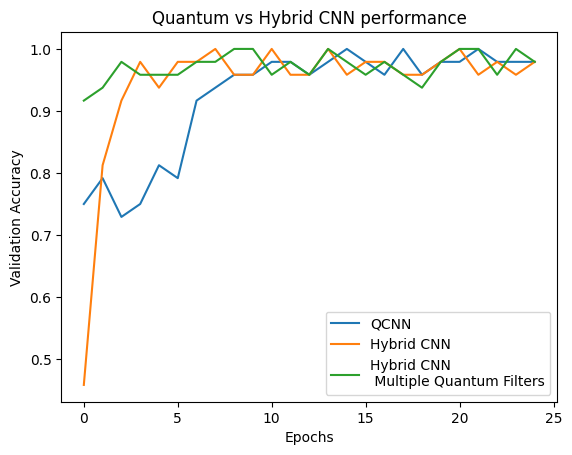

In [57]:
plt.plot(history.history['val_custom_accuracy'][:25], label='QCNN')
plt.plot(hybrid_history.history['val_custom_accuracy'][:25], label='Hybrid CNN')
plt.plot(multi_qconv_history.history['val_custom_accuracy'][:25],
         label='Hybrid CNN \n Multiple Quantum Filters')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

This plot compares the **validation accuracy** of three different models across 25 epochs:

1. **QCNN (Quantum Convolutional Neural Network)** - Blue line
2. **Hybrid CNN** - Orange line
3. **Hybrid CNN with Multiple Quantum Filters** - Green line

Each line represents the model's validation accuracy over the epochs, providing insight into how each model learns and generalizes on unseen data. Here’s a detailed breakdown of each component and the insights drawn from the plot.

***Plot Components***

1. **Axes**:
   - **X-axis (Epochs)**: Represents the number of training epochs, ranging from 0 to 25. Each epoch corresponds to one complete pass through the training data.
   - **Y-axis (Validation Accuracy)**: Represents the accuracy of each model on the validation dataset. Higher accuracy indicates better model performance on unseen data.

2. **Lines**:
   - **Blue Line (QCNN)**: Represents the validation accuracy of the pure Quantum Convolutional Neural Network (QCNN) model.
   - **Orange Line (Hybrid CNN)**: Represents the validation accuracy of the Hybrid CNN model, which combines quantum and classical layers.
   - **Green Line (Hybrid CNN with Multiple Quantum Filters)**: Represents the validation accuracy of a Hybrid CNN model with multiple quantum filters, potentially extracting more complex features.

***Observations***

1. **Initial Training Phase (Epochs 0-5)**:
   - The **Hybrid CNN** (orange line) quickly gains high accuracy within the first few epochs, reaching approximately 90% accuracy by epoch 5. This suggests that the hybrid model learns faster and effectively utilizes both quantum and classical components.
   - The **QCNN** (blue line) also improves in accuracy but at a slower rate, stabilizing around 85-90% accuracy by epoch 5.
   - The **Hybrid CNN with Multiple Quantum Filters** (green line) initially learns quickly, reaching above 90% accuracy by epoch 5. This suggests that using multiple quantum filters may improve the model’s initial feature extraction capabilities.

2. **Stabilization and Performance Comparison**:
   - The **Hybrid CNN** and **Hybrid CNN with Multiple Quantum Filters** both achieve high accuracy, fluctuating around 95-100% after epoch 5, suggesting they are both effective at generalizing to validation data.
   - The **QCNN** stabilizes slightly lower, around 85-90%, indicating that it may be less capable of capturing complex patterns compared to the hybrid models.

3. **Fluctuations**:
   - The **Hybrid CNN** and **Hybrid CNN with Multiple Quantum Filters** both exhibit slight fluctuations in accuracy between epochs. This is typical in models that are sensitive to validation data variations, potentially due to smaller validation datasets or model sensitivity.
   - The **QCNN** line is relatively stable but does not reach the same level of performance as the hybrid models, showing fewer fluctuations but lower overall accuracy.

***Insights***

1. **Hybrid Model Superiority**:
   - Both hybrid models (with and without multiple quantum filters) outperform the pure QCNN. This suggests that combining quantum and classical layers allows for better feature extraction and learning, likely because classical layers complement the quantum layers' feature extraction.

2. **Impact of Multiple Quantum Filters**:
   - The Hybrid CNN with Multiple Quantum Filters achieves comparable accuracy to the regular Hybrid CNN but maintains a consistently high performance after the initial epochs. This may suggest that multiple quantum filters help extract a richer set of features, making the model more robust.

3. **QCNN Limitations**:
   - While the QCNN performs reasonably well, it does not reach the same accuracy levels as the hybrid models. This could indicate that a purely quantum approach may be limited in capturing all the necessary patterns in the data for this task.

4. **Potential Overfitting**:
   - The Hybrid CNN models achieve near-perfect accuracy in some epochs. If the validation dataset is not representative enough, this could be a sign of overfitting. However, if the dataset is sufficient, this high accuracy indicates the models are highly effective.

***Summary***

- The **Hybrid CNN with Multiple Quantum Filters** and **Hybrid CNN** models consistently outperform the **QCNN** in terms of validation accuracy.
- The **Hybrid CNN with Multiple Quantum Filters** shows slightly more robustness, likely due to the added complexity and feature extraction capability of multiple quantum filters.
- The results suggest that hybrid models leveraging both quantum and classical components are more effective for this task than purely quantum models.

This plot highlights the advantage of hybrid quantum-classical architectures for certain tasks, demonstrating that they can outperform purely quantum models in terms of both learning speed and accuracy.

---

The final conclusion of this project comparing Quantum Convolutional Neural Networks (QCNNs) and Hybrid Convolutional Neural Networks (Hybrid CNNs) in detecting patterns in quantum data can be summarized as follows:

# Key Conclusions

1. **Hybrid Models Outperform Purely Quantum Models**:
   - Throughout the training, the hybrid models (especially the **Hybrid CNN with Multiple Quantum Filters**) consistently achieved higher validation accuracy than the pure QCNN.
   - The ability to combine quantum feature extraction with classical processing layers allows the hybrid models to capture and process more complex patterns than the purely quantum QCNN. This suggests that hybrid architectures can leverage the strengths of both quantum and classical processing to improve learning outcomes.

2. **Multiple Quantum Filters Add Value**:
   - The **Hybrid CNN with Multiple Quantum Filters** performed slightly better and more stably than the regular Hybrid CNN, demonstrating that incorporating multiple quantum filters can enhance feature extraction in quantum data.
   - By applying multiple quantum circuits in parallel, the model extracts a richer and more diverse set of features, allowing it to be more robust and potentially more accurate, especially on complex tasks.

3. **Efficiency and Learning Speed**:
   - The Hybrid CNN models achieved high accuracy within the first few epochs, indicating faster learning compared to the QCNN.
   - This efficiency is beneficial in practical applications where quick convergence and high performance are required, especially when training with quantum resources, which can be limited.

4. **Implications for Quantum Machine Learning**:
   - The results demonstrate that **quantum-classical hybrid models** are highly promising for quantum machine learning, especially in scenarios where pure quantum models may fall short.
   - Hybrid models are likely to be a practical choice for many near-term applications in quantum computing, where fully quantum approaches may lack sufficient computational power or complexity to outperform hybrid architectures.

5. **Potential for Generalization**:
   - The hybrid models' ability to generalize well on validation data without significant overfitting (as indicated by similar training and validation performance) suggests that they are effective for broader applications beyond this specific dataset.

# Overall Conclusion

This project highlights the strength of **hybrid quantum-classical models** in quantum machine learning. By combining quantum circuits' unique ability to process quantum data with classical neural networks' robust optimization and learning power, hybrid models provide a compelling solution that currently outperforms purely quantum approaches in accuracy, efficiency, and generalization.

As quantum computing technology continues to advance, these findings underscore the potential of hybrid architectures to play a central role in practical quantum machine learning applications, particularly as we bridge the gap between classical and quantum processing capabilities.

---

# Conclusion

This project concludes that **Hybrid CNN models outperform purely quantum QCNNs** in terms of accuracy, stability, and generalization when detecting patterns in quantum data. Key insights include:
- **Superior Performance of Hybrid Models**: Hybrid CNNs, especially with multiple quantum filters, achieved higher validation accuracy and more stable performance than the QCNN. This suggests that the combination of quantum feature extraction and classical processing enables better learning.
- **Value of Multiple Quantum Filters**: The Hybrid CNN with multiple quantum filters demonstrated increased robustness and slightly better performance, highlighting the importance of richer feature extraction through parallel quantum circuits.
- **Limitations of Pure Quantum Models**: While the QCNN was effective, it fell short of the hybrid models' performance, indicating that purely quantum approaches may struggle to capture complex patterns in some cases.

The findings suggest that **quantum-classical hybrid models are better suited for quantum machine learning tasks** on current quantum hardware, where limited qubit counts and circuit depths can constrain purely quantum models.

---

# Future Prospects

1. **Scalability with Larger Datasets and Deeper Circuits**:
   - Test the scalability of hybrid models with larger quantum datasets and more complex quantum circuits, assessing performance on more challenging quantum pattern detection tasks.

2. **Exploration of Different Quantum Architectures**:
   - Experiment with other quantum architectures, such as Quantum Long Short-Term Memory (QLSTM) and Quantum Transformers, to investigate their potential in hybrid setups.

3. **Integration with Real-World Quantum Data**:
   - Apply these models to real-world quantum data sources, such as quantum simulation results or experimental quantum computing data, to validate performance outside of synthetic datasets.

4. **Optimizing Quantum Resource Usage**:
   - Explore techniques to further minimize quantum resource usage, making hybrid models more accessible and cost-effective on near-term quantum devices.

5. **Investigating Transfer Learning for Quantum Models**:
   - Explore the potential for transfer learning in hybrid quantum-classical models, where a model trained on one type of quantum data could be fine-tuned to work with other quantum datasets.

6. **Application Across Industries**:
   - Deploy hybrid quantum-classical models in industries such as finance, healthcare, and logistics, where pattern detection in quantum data could offer substantial benefits, such as enhanced cryptographic security, optimized logistics, and accelerated drug discovery.

By advancing hybrid quantum-classical models, this project provides a foundation for effective quantum machine learning, paving the way for practical applications and helping bridge the gap between quantum capabilities and real-world impact.